# ASMSA: Tune AAE model hyperparameters

**Previous step**
- [prepare.ipynb](prepare.ipynb): Download and sanity check input files

**Next steps**
- [train.ipynb](train.ipynb): Use results of previous tuning in more thorough training
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

## Notebook setup

In [1]:
threads = 2
import os
os.environ['OMP_NUM_THREADS']=str(threads)
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
import tensorflow as tf

# PyTorch favours OMP_NUM_THREADS in environment
import torch

# Tensorflow needs explicit cofig calls
tf.config.threading.set_inter_op_parallelism_threads(threads)
tf.config.threading.set_intra_op_parallelism_threads(threads)

2024-10-14 11:57:16.824870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 11:57:16.837584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 11:57:16.841444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 11:57:16.852810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 11:57:17.601304: W tensorflow/compiler/tf2

In [2]:
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import urllib.request
from tensorflow import keras
import keras_tuner
import asmsa
from datetime import datetime
import tensorflow as tf

2024-10-14 11:57:20.478849: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:198] Using CUDA malloc Async allocator for GPU: 0
2024-10-14 11:57:20.480200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8098 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0


## Input files

All input files are prepared (up- or downloaded) in [prepare.ipynb](prepare.ipynb). 


In [3]:
exec(open('inputs.py').read())

## Load dataset

In [4]:
# load train dataset
X_train = tf.data.Dataset.load('datasets/intcoords/train')
X_train_np = np.stack(list(X_train))
X_train_np = X_train_np[:int(0.5*len(X_train_np))]

# load validation dataset
X_validate = tf.data.Dataset.load('datasets/intcoords/validate')
X_validate_np = np.stack(list(X_validate))

X_train_np.shape, X_validate_np.shape

2024-10-14 11:57:23.626521: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-14 11:57:24.773572: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


((15644, 1419), (7830, 1419))

## Hyperparameter definition
Specify hyperparameter ranges

In [5]:
medium_hp = {
    'activation' : ['relu','gelu','selu'],
    'ae_neuron_number_seed' : [32,96,128],
    'disc_neuron_number_seed' : [32,96],
    'ae_number_of_layers' : [2,5],
    'disc_number_of_layers' : [2,5],
    'batch_size' : [64,128,256,512],
    'optimizer' : ['Adam'],
    'learning_rate' : 0.0002,
    'ae_loss_fn' : ['MeanSquaredError'],
    'disc_loss_fn' : ['BinaryCrossentropy']
}

tiny_hp = {
    'activation' : ['relu'],
    'ae_neuron_number_seed' : [32,96],
    'disc_neuron_number_seed' : [32,96],
    'ae_number_of_layers' : [2,2],
    'disc_number_of_layers' : [3,3],
    'batch_size' : [64,128,256],
    'optimizer' : ['Adam'],
    'learning_rate' : 0.0002,
    'ae_loss_fn' : ['MeanSquaredError'],
    'disc_loss_fn' : ['BinaryCrossentropy']
}

## Sequential hyperparameter tuning

This is robust, it does not require Kubernetes environment for additional job submission but GPU is strongly recommended in the notebook itself to get reasonable speed, not requiring the following (currently broken) parallel tuning section.


In [6]:
# Just testing numbers of epochs and hyperparameter setting trials
# Don't expect anything meaningful
trials=50
epochs=30

normal = tfp.distributions.Normal(loc=0, scale=1)
#gm = asmsa.GaussianMixture([[-1,-1],[.8,1],[1,-.8]],[[1,1],[.5,.5],[.5,.5]],[.6,.25,.15])
gm=asmsa.GaussianMixture([[-1,-1],[1,1]],[[.2,.2],[.5,.5]],[.6,.4])

# Set RESULTS_DIR env variable for results of tuning
os.environ['RESULTS_DIR'] = datetime.today().strftime("%m%d%Y-%H%M%S")
tuner = keras_tuner.RandomSearch(
    max_trials=trials,
    hypermodel=
        asmsa.AAEHyperModel(
            (X_validate_np.shape[1],),
            hp=medium_hp,
            prior=normal), # gm), #normal),
    objective=keras_tuner.Objective("score", direction="min"),
    directory="./results",
    project_name="Random",
    overwrite=True
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
tuner.search(train=X_train_np,validation=X_validate_np,epochs=epochs,verbose=2)

Trial 46 Complete [00h 00m 41s]
score: 0.27499376320697666

Best score So Far: 0.1535467840592782
Total elapsed time: 00h 48m 20s


In [8]:
from asmsa.tuning_analyzer import TuningAnalyzer

# Create analyzer object that analyses results of tuning
# By default it is the latest tuning, but can by choosen with tuning flag,
#  e.g TuningAnalyzer(tuning='analysis/05092023-135249')
analyzer = TuningAnalyzer()

Analyzing tuning from: /home/jovyan/ASMSA/analysis/10142024-115724/


In [9]:
# Get sorted hyperparameters by score, by default 10 best HP, for different number:
#  analyzer.get_best_hp(num_trials=3)
analyzer.get_best_hp()

Printing results of tuning: /home/jovyan/ASMSA/analysis/10142024-115724/
-----(1)-----
Trial ID: d749678d8a3985db3e51c20867d1390f3623ec4328a701421b171fc0f3b40982
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.1535467840592782
-----(2)-----
Trial ID: 3c27b3d275872d253f42d243e94532ef14986f4643cfbb16c5484ee9709c2e09
Hyperparameters:
activation: relu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 128
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.1544874129651062
-----(3)-----
Trial ID: b05c6c6345362ad81874e5f8a55f5a65d4d31a9a91c1785d32eff1980b1460b6
Hyperparameters:
activation: relu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.1551909

Trial ID: d749678d8a3985db3e51c20867d1390f3623ec4328a701421b171fc0f3b40982


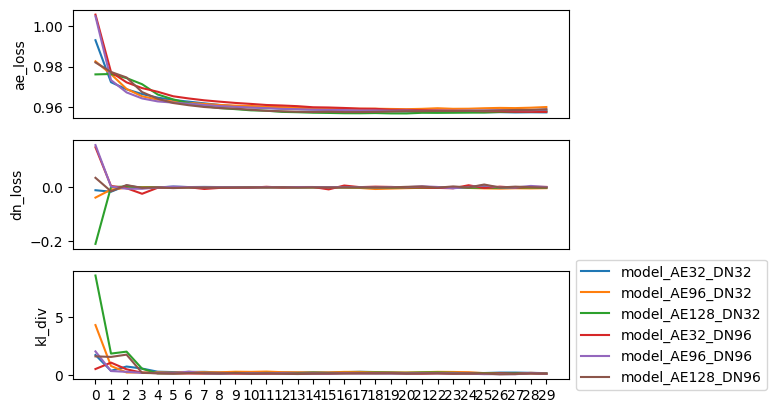

Trial ID: 3c27b3d275872d253f42d243e94532ef14986f4643cfbb16c5484ee9709c2e09


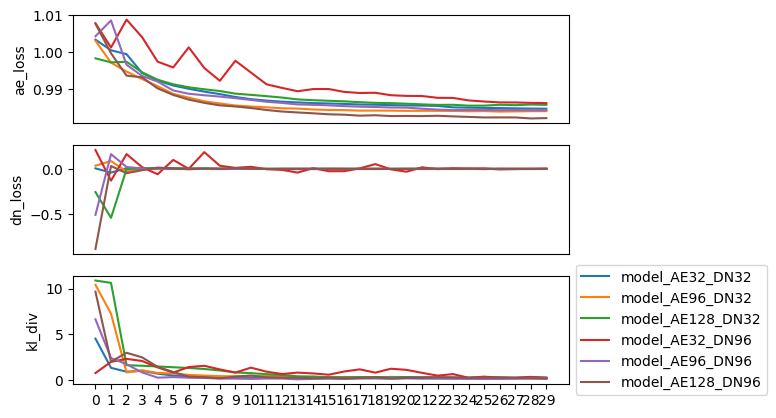

Trial ID: b05c6c6345362ad81874e5f8a55f5a65d4d31a9a91c1785d32eff1980b1460b6


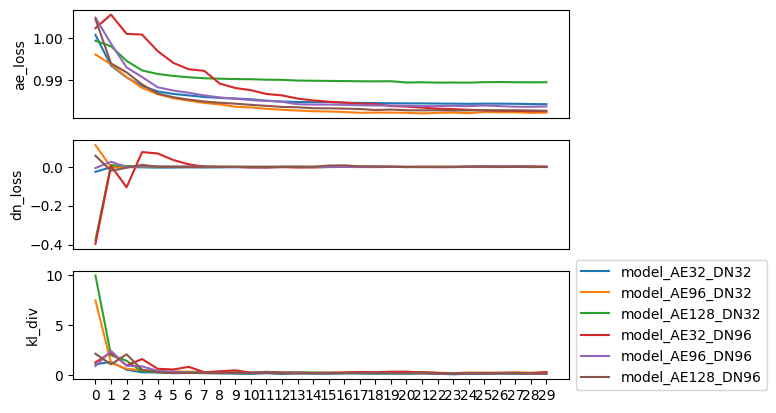

Trial ID: b1eb76f15b40074691ff533f100f916a6610050d7f46cf75f3596a5353ea0851


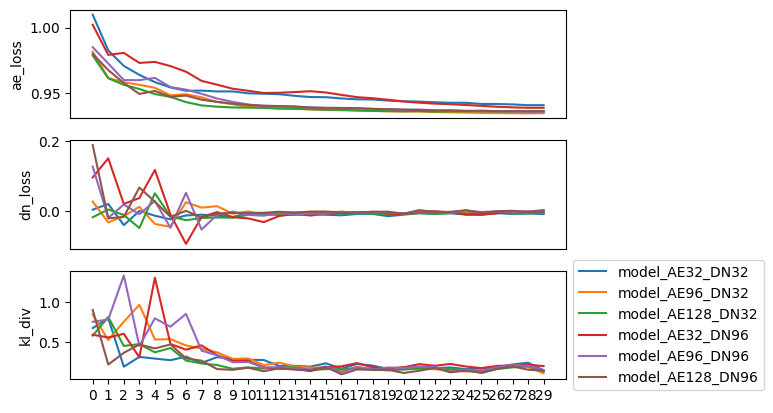

Trial ID: d39caa96705b907405020bf0d82f87ebf36b194969036dd777456a56563db16b


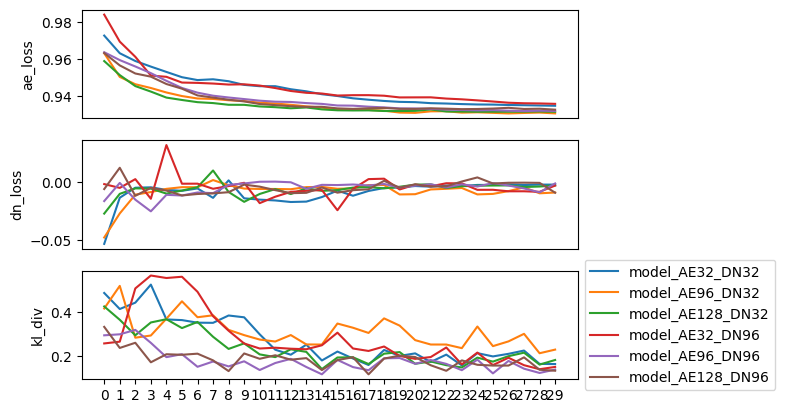

Trial ID: d824e0a6b1a770a953f2ffa119f25da5118449bc774e7dc0eaaf6a7e203a98a1


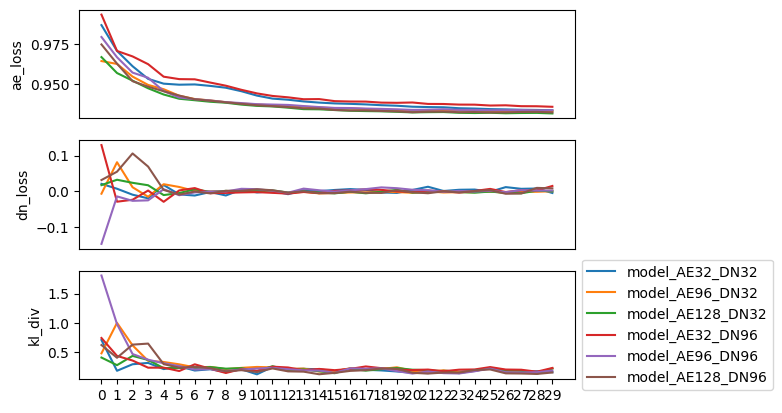

Trial ID: 759e825d296f12dca3e4fa032f6fb15fd8d67f8f5f6bba7aa500eb79e1fd2968


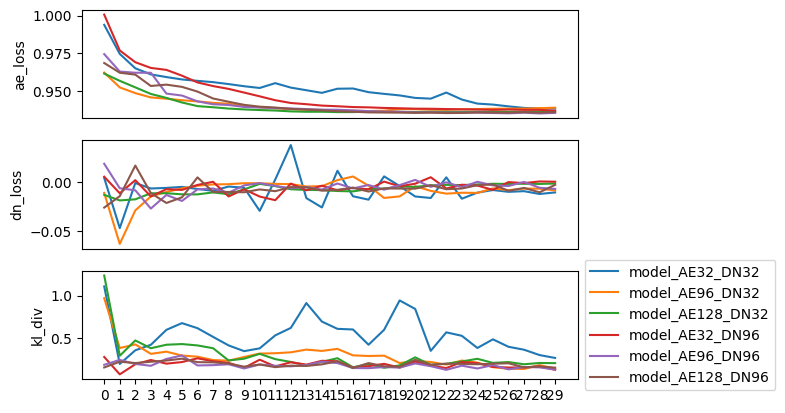

Trial ID: 5c0036a7a9c0544a2a89ceb46fac627bda7ba83dcddbb176e25e4d94389b07e7


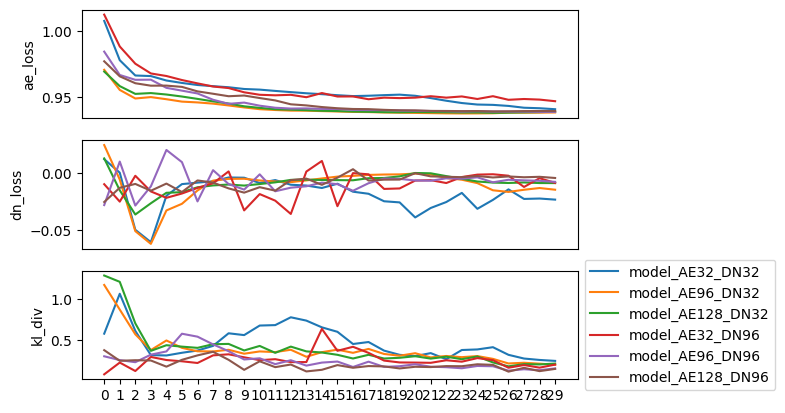

Trial ID: 759ccc81bf1a31397199bf177aebce5926039332a5d0208dba9003fd23ab10ee


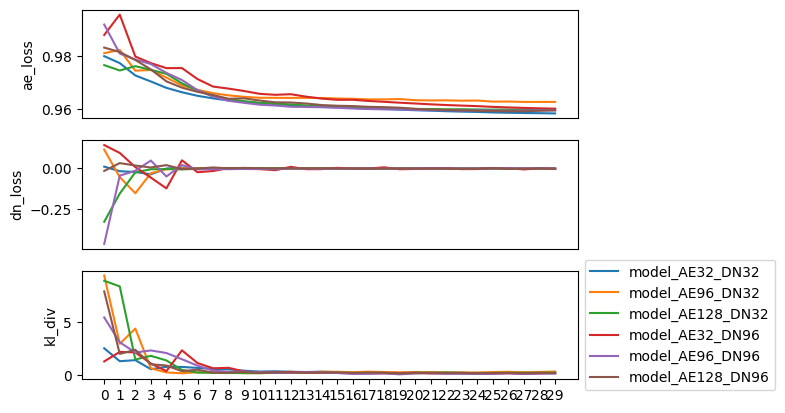

Trial ID: f8507b101a06c3516ef608f1a0de0ca56d31dea75f7f3551450d7aa27179df9c


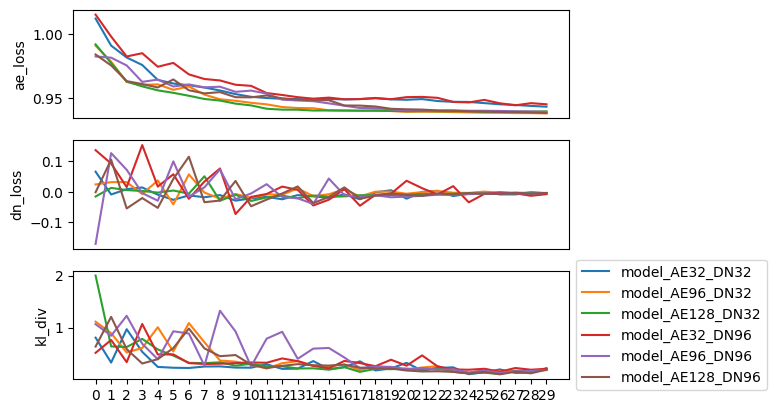

In [10]:
# Matplotlib visualization - not recommended way, does not look that good and does not scale 
#  that well but at least the colors are consistent accross measures. After more work could look better
# - By default visualizing best 10 trials
# - Can specify only one specific trial... analyzer.visualize_tuning(trial='15d9fa928a7517004bcb28771bb6e5f17ad66dd7013c6aa1572a84773d91393c')
# - Can specify number of best trials to be visualized... analyzer.visualize_tuning(num_trials=3)
analyzer.visualize_tuning()

In [11]:
# Recommended option via Tensorboard. This function populates TB event
#  which can be viewed in native way via Tensorboard. 
# May not work in all Jupyterhub setups, though.

# By default it chooses latest tuning and populates into its directory _TB, e.g: analysis/05092023-135249/_TB
# - Can override directory where to populate... analyzer.populate_TB(out_dir='MyTBeventDir')
# - Can choose only specific trials via list... analyzer.populate_TB(trials=['15d9fa928a7517004bcb28771bb6e5f17ad66dd7013c6aa1572a84773d91393c']),
# - Can select how many best trials to be visualized... analyzer.populate_TB(num_trials=3)
analyzer.populate_TB(num_trials=3)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir analysis

## Parallel hyperparameter tuning

**BROKEN**, ignore the rest of this notebook for the time being

In [ ]:
# Finally, this is the real stuff
# medium settings known to be working for trpcage

epochs=15
trials=3
hp=medium_hp

# testing only
#epochs=8
#trials=6
#hp=tiny_hp

In [ ]:
# number of parallel workers, each runs a single trial at time
# balance between resource availability and size of the problem
# currently each slave runs on 4 cores and 4 GB RAM (hardcoded in src/asmsa/tunewrapper.py)

slaves=3

In [ ]:
# XXX: Kubernetes magic: find out names of container image and volume
# check the result, it can go wrong

with open('IMAGE') as img:
    image=img.read().rstrip()

import re
mnt=os.popen('mount | grep /home/jovyan').read()
pvcid=re.search('pvc-[0-9a-z-]+',mnt).group(0)
pvc=os.popen(f'kubectl get pvc | grep {pvcid} | cut -f1 -d" "').read().rstrip()

print(f"""\
image: {image}
volume: {pvc}
""")

In [ ]:
# Python wrapper around scripts that prepare and execute parellel Keras Tuner in Kubernetes
from asmsa.tunewrapper import TuneWrapper

wrapper = TuneWrapper(ds=X_validate_np,hp=hp,output=datetime.today().strftime("%m%d%Y-%H%M%S"),epochs=epochs,trials=trials,pdb=conf,top=topol,xtc=traj,ndx=index, pvc=pvc)

In [ ]:
# Necessary but destructive cleanup before hyperparameter tuning

# DON'T RUN THIS CELL BLINDLY
# it kills any running processes including the workers, and it purges previous results

!kubectl delete job/tuner
!kill $(ps ax | grep tuning.py | awk '{print $1}')
!rm -rf results

In [ ]:
# start the master (chief) of tuners in background
# the computation takes rather long, this is a more robust approach then keeping it in the notebook

wrapper.master_start()

In [ ]:
# therefore one should check the status ocassionally; it should show a tuning.py process running
print(wrapper.master_status())

In [ ]:
# spawn the requested number of workers as separate Kubernetes job with several pods 
# they receive work from 

wrapper.workers_start(num=slaves)

In [ ]:
# This status should show {slaves} number of pods, all of them start in Pending state, and follow through ContainerCreating 
# to Running, and Completed finally

# This takes time, minutes to hours depending on size of the model, number of trials, and number of slaves
# Run this cell repeatedly, waiting until all the pods are completed

wrapper.workers_status()

In [ ]:
# Same steps for analysis as with serial tuning
analyzer = TuningAnalyzer()
analyzer.get_best_hp()

In [ ]:
# We can choose output dir for TB event this time
out = 'dist_tuning'

analyzer.populate_TB(out_dir=out)

In [ ]:
# Might need to kill previous tensorboard instance to change logdir
!pkill -f 'tensorboard'

%load_ext tensorboard
%tensorboard --logdir $out